In [1]:
from statistics import LinearRegression

import CONSTANTS
from functions import *
import warnings
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformer_classes import *
from tqdm import tqdm
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
from xgboostImplementation import XGBoost
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')

# Utilize the training cols to train an xgboost implementation

In [2]:
data = pd.read_csv(f'../{fullDataPath('BTC')}')

In [3]:
# Convert time to datetime if it's not already
data['time'] = pd.to_datetime(data['time'], errors='coerce')
data = data.dropna(subset=['time'])

# Extract date component
data['date'] = data['time'].dt.date

# Group by date and aggregate values (one row per day)
# Hard coded change later
daily_data = (
    data
    .groupby('date')
    .agg(
        close=('close', 'last'),  # Take the last close price of the day
        avg_sentiment=('score', 'mean'),  # Average sentiment for the day
        tweet_count=('score', 'count'),   # Number of observations per day
        volume=('volume', 'last'),          # Total volume for the day
        BB_Lower=('BB_Lower', 'last'),  # Last value of BB lower band
        BB_Middle=('BB_Middle', 'last'),  # Last value of BB middle band
        BB_Upper=('BB_Upper', 'last'),  # Last value of BB upper band
        SMA_50=('SMA_50', 'last'),  # Last value of SMA 50
        Volume_MA_20=('Volume_MA_20', 'last'),  # Last value of Volume MA 20
        value=('value', 'last'),
        value_classification=('value_classification', 'last'),
        OBV=('OBV', 'last')
    )
    .reset_index()
)

# Convert date back to datetime format if needed
daily_data['time'] = pd.to_datetime(daily_data['date'])
daily_data = daily_data.drop('date', axis=1)

# Sort by time
daily_data = daily_data.sort_values('time')
daily_data.set_index('time', inplace=True)
daily_data['gradient'] = daily_data['close'].diff().fillna(0.0)
daily_data

,close,avg_sentiment,tweet_count,volume,BB_Lower,BB_Middle,BB_Upper,SMA_50,Volume_MA_20,value,value_classification,OBV,gradient
time,,,,,,,,,,,,,
2015-07-20,280.00,0.0,1,782.883420,268.225209,283.7070,299.188791,257.5800,4944.509312,51.0,Neutral,-3.756559e+06,0.00
2015-07-21,277.32,0.0,1,4943.559434,266.070954,283.0885,300.106046,256.8628,5157.713985,51.0,Neutral,-3.757342e+06,-2.68
2015-07-22,277.89,0.0,1,4687.909383,263.804410,282.4800,301.155590,256.0914,5184.465121,51.0,Neutral,-3.752399e+06,0.57
2015-07-23,277.39,0.0,1,5306.919575,263.024045,282.1850,301.345955,255.3040,5239.876891,51.0,Neutral,-3.757087e+06,-0.50
2015-07-24,289.12,0.0,1,7362.469083,261.412051,281.6625,301.912949,254.5742,5292.043713,51.0,Neutral,-3.751780e+06,11.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13,106118.70,0.0,1,7440.850143,101853.255304,105866.7070,109880.158696,104099.2136,0.000000,54.0,Neutral,9.414340e+03,397.65
2025-06-14,105465.42,0.0,1,2256.484581,101853.255304,105866.7070,109880.158696,104099.2136,0.000000,52.0,Neutral,1.973490e+03,-653.28
2025-06-15,105599.25,0.0,1,1722.809452,101853.255304,105866.7070,109880.158696,104099.2136,0.000000,50.0,Neutral,4.229974e+03,133.83


<Axes: xlabel='time'>

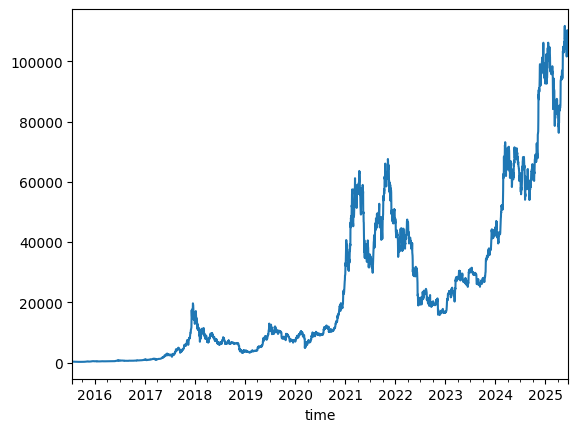

In [4]:
RESPONSE_VARIABLE = 'close'
daily_data[RESPONSE_VARIABLE].plot.line()

Only keep the columns as specified in the training columns file

In [5]:
trainingCols = open(f'../{TRAINING_COLUMNS}', 'r').readlines()
trainingCols = [i.strip() for i in trainingCols]


testSize = len(daily_data) - 365 * 3
train_data = daily_data.iloc[:testSize]
test_data = daily_data.iloc[testSize:]
print('Train Index:', train_data.index.min(), train_data.index.max())
print('Test Index:', test_data.index.min(), test_data.index.max())
scaler = StandardScaler()
X_train = pd.get_dummies(train_data[trainingCols])
y_train = train_data[RESPONSE_VARIABLE]
X_test = pd.get_dummies(test_data[trainingCols])
y_test = test_data[RESPONSE_VARIABLE]
xTrainCols = X_train.columns
xTrainIdx = X_train.index
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train), columns=xTrainCols, index=xTrainIdx)
X_test_normalized = pd.DataFrame(scaler.transform(X_test), columns=xTrainCols, index=X_test.index)
y_train_normalized = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_train_normalized = pd.Series(y_train_normalized, index=y_train.index, name=RESPONSE_VARIABLE)
y_test_normalized = scaler.transform(y_test.values.reshape(-1, 1)).flatten()
y_test_normalized = pd.Series(y_test_normalized, index=y_test.index, name=RESPONSE_VARIABLE)

Train Index: 2015-07-20 00:00:00 2022-06-18 00:00:00
Test Index: 2022-06-19 00:00:00 2025-06-17 00:00:00


In [6]:
baseModel = RandomForestRegressor(n_estimators=50, min_samples_leaf=7, random_state=42)
xgb_model = XGBoost(
    base_estimator=baseModel,
    n_estimators=50,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)
# cv_params = xgb_model.cross_validate(X_train_normalized, y_train_normalized, return_train_score=True)
# cv_params

In [7]:
baseModels = [
    baseModel,
    LinearRegression(),
    DecisionTreeRegressor(min_samples_split=4, max_depth=8),
    RandomForestRegressor(n_estimators=50)
]
xgb_models = [XGBoost(base_estimator=i) for i in baseModels]

In [ ]:
param_grid = {
        'n_estimators': np.arange(10, 100, 40),
        'learning_rate': [1e-4, 1e-3, 1e-2],
        'max_depth': [3, 5, 8, 15, 25],
        'subsample': [0.8, 1.0],
}
everything = pd.DataFrame()
for xgbm in xgb_models:
    best_params = xgbm.tune_hyperparameters(X_train_normalized, y_train_normalized, param_grid=param_grid, cv=5)
    df = xgbm.get_tuning_results()
    df['base_estimator'] = str(xgbm._get_base_estimator())
    everything = pd.concat([everything, df])
everything.groupby('base_estimator')['mean_score'].mean()

 23%|██▎       | 21/90 [00:19<01:24,  1.23s/it]

In [9]:
param_grid = {
        'n_estimators': np.arange(10, 100, 50),
        'learning_rate': [1e-4, 1e-3, 1e-2],
        'max_depth': [3, 5, 8, 15, 25],
        'subsample': [0.8, 1.0],
}
best_params = xgb_model.tune_hyperparameters(X_train_normalized, y_train_normalized, param_grid=param_grid, cv=5)

100%|██████████| 60/60 [00:57<00:00,  1.05it/s]


In [29]:
xgb_model.get_tuning_results()

,learning_rate,max_depth,n_estimators,subsample,mean_score,std_score,rank
0,0.0100,15,60,1.0,0.625084,0.407774,1
1,0.0100,15,60,0.8,0.625178,0.405466,2
2,0.0100,25,60,1.0,0.625390,0.407965,3
3,0.0100,8,60,1.0,0.625576,0.406443,4
4,0.0100,25,60,0.8,0.625909,0.405626,5
5,0.0100,8,60,0.8,0.627243,0.405297,6
6,0.0100,5,60,0.8,0.629680,0.398652,7
7,0.0100,5,60,1.0,0.631377,0.399745,8
8,0.0100,3,60,0.8,0.632190,0.383792,9
9,0.0100,3,60,1.0,0.634707,0.386291,10


In [11]:
model = XGBoost(
    **best_params,
    base_estimator=baseModel,
    random_state=xgb_model.random_state
)
model.fit(X_train_normalized, y_train_normalized)

XGBoost(base_estimator=RandomForestRegressor(min_samples_leaf=7,
                                             n_estimators=50, random_state=42),
        learning_rate=0.01, max_depth=30, n_estimators=30, random_state=42)

<Axes: xlabel='time'>

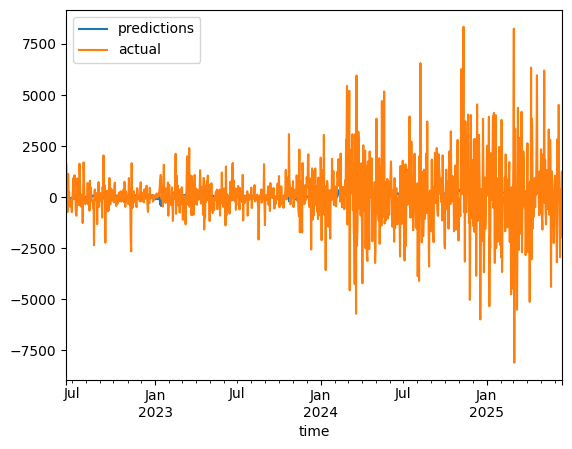

In [12]:
predictions = model.predict(X_test_normalized)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
comparison = pd.DataFrame({
    'predictions': predictions,
    'actual': y_test
})
comparison.plot.line()

In [22]:
(mean_squared_error(comparison['predictions'], comparison['actual']) ** 0.5) / y_test.std()

0.9978709855727232

In [33]:
def function(a, b):
    return a+b

kwargs = {
    'a': 1,
    'b': 4
}
function(**kwargs)

5